### imports

In [206]:
import pjlsa_gsipro as pjlsa

import random
import time
import json
from datetime import datetime

import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
from pyda import SimpleClient
from pyda.data import DataFilter, TimingSelector
from pyda_rda3 import RdaProvider

In [3]:
import jpype
with pjlsa.LSAClientGSI().java_api():
    from cern.lsa.client import ServiceLocator, ContextService, ParameterService, TrimService, SettingService
    from cern.accsoft.commons.value import ValueFactory
    from cern.lsa.domain.settings import TrimRequest, ContextSettingsRequest, Settings, SettingPartEnum
    from cern.lsa.domain.settings.type import  BeamProcessPurposes
    from de.gsi.lsa.domain.settings import GsiBeamProcessPurpose
    from java.util import Set, Collections

 INFO [07 Nov 2023 13:44:19,769] (PropertyConfig.java) - Processing property file http://asl156.acc.gsi.de:58080/application/profile/pro/lsa.properties.
 INFO [07 Nov 2023 13:44:19,848] (PropertyConfig.java) - Populating system properties.
 INFO [07 Nov 2023 13:44:19,849] (PropertyConfig.java) - Setting property lsa.masp.deviceName=ZMA_ZS
 INFO [07 Nov 2023 13:44:19,849] (PropertyConfig.java) - Setting property contextCategories=MD,OPERATIONAL,TEST
 INFO [07 Nov 2023 13:44:19,850] (PropertyConfig.java) - Setting property lsa.bss.dataSupplyEnabled=true
 INFO [07 Nov 2023 13:44:19,850] (PropertyConfig.java) - Setting property lsa.trim.concurrency.enabled=true
 INFO [07 Nov 2023 13:44:19,850] (PropertyConfig.java) - Setting property cavity.phase.changeatmerging=true
 INFO [07 Nov 2023 13:44:19,851] (PropertyConfig.java) - Setting property lsa.sis18.noBeamStrict=true
 INFO [07 Nov 2023 13:44:19,851] (PropertyConfig.java) - Setting property cavity.h2.maxlimit=8000
 INFO [07 Nov 2023 13:44:1

In [4]:
ts = ServiceLocator.getService(TrimService)
cs = ServiceLocator.getService(ContextService)
ps = ServiceLocator.getService(ParameterService)
ss = ServiceLocator.getService(SettingService)

lsa.server.properties = lsa-gsi-pro-server.properties
DEBUG [07 Nov 2023 13:44:20,562] (AbstractApplicationContext.java) - Refreshing org.springframework.context.annotation.AnnotationConfigApplicationContext@710b18a6
DEBUG [07 Nov 2023 13:44:20,593] (DefaultSingletonBeanRegistry.java) - Creating shared instance of singleton bean 'org.springframework.context.annotation.internalConfigurationAnnotationProcessor'
DEBUG [07 Nov 2023 13:44:20,675] (PropertySourcesPropertyResolver.java) - Found key 'lsa.server.properties' in PropertySource 'systemProperties' with value of type String
DEBUG [07 Nov 2023 13:44:20,686] (PropertySourcesPropertyResolver.java) - Found key 'lsa.server.properties' in PropertySource 'systemProperties' with value of type String
DEBUG [07 Nov 2023 13:44:20,703] (PropertySourcesPropertyResolver.java) - Found key 'lsa.server.properties' in PropertySource 'systemProperties' with value of type String
DEBUG [07 Nov 2023 13:44:20,869] (DefaultSingletonBeanRegistry.java) - Cre

In [5]:
TERMINAL_COLORS = [
"\u001b[31m", "\u001b[32m", "\u001b[33m", "\u001b[34m", "\u001b[35m", "\u001b[36m", "\u001b[37m", "\u001b[31;1m", "\u001b[32;1m", "\u001b[33;1m", "\u001b[34;1m", "\u001b[35;1m",
]

TERMINAL_COLOR_RESET = "\u001b[0m"


## fetch pattern and related beam processes

In [69]:
# pattern = cs.findPattern("SCRATCH_RM_SIS18_PYTHON_TEST_20220728_124253")

# pattern = cs.findPattern("SIS18_FAST_HHD_12C6_HOCHSTROM_4H1")
# pattern = cs.findPattern("SIS18_SLOW_HHD_20231105_000608")
pattern = cs.findPattern("SIS18_SLOW_HADES_20231106_171354")

DEBUG [07 Nov 2023 14:57:38,913] (RbaTokenLookup.java) - Rba token not found.
DEBUG [07 Nov 2023 14:57:38,913] (Slf4jLogger.java) - [ApplicationFeignService#checkServerVersionCompatibility] ---> GET http://lsapro00a.acc.gsi.de:52330/application/checkServerVersionCompatibility/18.2.1 HTTP/1.1
DEBUG [07 Nov 2023 14:57:38,913] (Slf4jLogger.java) - [ApplicationFeignService#checkServerVersionCompatibility] Accept: application/json
DEBUG [07 Nov 2023 14:57:38,913] (Slf4jLogger.java) - [ApplicationFeignService#checkServerVersionCompatibility] Accept-Charset: utf-8
DEBUG [07 Nov 2023 14:57:38,913] (Slf4jLogger.java) - [ApplicationFeignService#checkServerVersionCompatibility] Content-Type: application/json;charset=UTF-8
DEBUG [07 Nov 2023 14:57:38,914] (Slf4jLogger.java) - [ApplicationFeignService#checkServerVersionCompatibility] x-client-id: app=/home/bphy/ccaliari/lnx/miniforge3/envs/pjlsa_pro/bin/python3.9;uid=ccaliari;host=asl753.acc.gsi.de;pid=740027;
DEBUG [07 Nov 2023 14:57:38,914] (Slf4

In [70]:
beamProcesses = list(pattern.getBeamProcesses())

for i, p in enumerate(beamProcesses):
    print(i, p.getName())

0 SIS18_SLOW_HADES_20231106_171354.C1.GHHTMU1_TO_GTH3MU1.BEAMOUT_INIT.1
1 SIS18_SLOW_HADES_20231106_171354.C1.GTE3MU1_TO_GHHTMU1.BEAMOUT_INIT.1
2 SIS18_SLOW_HADES_20231106_171354.C1.GTH3MU1_TO_GTP1MU1.BEAMOUT_INIT.1
3 SIS18_SLOW_HADES_20231106_171354.C1.GTP1MU1_TO_HADES.BEAMOUT_INIT.1
4 SIS18_SLOW_HADES_20231106_171354.C1.GTS1MU1_TO_GTE3MU1.BEAMOUT_INIT.1
5 SIS18_SLOW_HADES_20231106_171354.C1.SIS18_TO_GTS1MU1.BEAMOUT_INIT.1
6 SIS18_SLOW_HADES_20231106_171354.C1.GTK7BC1L_TO_PLTKMH2__GS.BEAMOUT_INIT.1
7 SIS18_SLOW_HADES_20231106_171354.C1.PLTKMH2_TO_SIS18__GS.BEAMOUT_INIT.1
8 SIS18_SLOW_HADES_20231106_171354.C1.SIS18_RING.BEAMOUT_INIT.1
9 SIS18_SLOW_HADES_20231106_171354.C1.GTK7BC1L_TO_PLTKMH2__GS.TRANSFER_INJECTION.1
10 SIS18_SLOW_HADES_20231106_171354.C1.PLTKMH2_TO_SIS18__GS.TRANSFER_INJECTION.1
11 SIS18_SLOW_HADES_20231106_171354.C1.SIS18_RING.RING_INJECTION.1
12 SIS18_SLOW_HADES_20231106_171354.C1.GTK7BC1L_TO_PLTKMH2__GS.BEAMOUT_RESET.1
13 SIS18_SLOW_HADES_20231106_171354.C1.PLTKMH2_

### beam process for tunescan

In [71]:
beamProcess_to_trim_id = 22
beamProcess_to_trim = beamProcesses[beamProcess_to_trim_id]
process_length = beamProcess_to_trim.getLength()  # ns
print("trim process {} has length {} ms".format(beamProcess_to_trim.getName(), process_length / 1e6))

parameterList = [
    ps.findParameterByName(p) for p in ["SIS18BEAM/QH","SIS18BEAM/QV",]
]

trim process SIS18_SLOW_HADES_20231106_171354.C1.SIS18_RING.RING_PRE_EXTRACTION.1 has length 0.09 ms
DEBUG [07 Nov 2023 14:57:56,089] (RbaTokenLookup.java) - Rba token not found.
DEBUG [07 Nov 2023 14:57:56,090] (Slf4jLogger.java) - [ParameterFeignService#getParameterByName] ---> GET http://lsapro00a.acc.gsi.de:52330/parameters/SIS18BEAM/QH HTTP/1.1
DEBUG [07 Nov 2023 14:57:56,090] (Slf4jLogger.java) - [ParameterFeignService#getParameterByName] Accept: application/json
DEBUG [07 Nov 2023 14:57:56,090] (Slf4jLogger.java) - [ParameterFeignService#getParameterByName] Accept-Charset: utf-8
DEBUG [07 Nov 2023 14:57:56,090] (Slf4jLogger.java) - [ParameterFeignService#getParameterByName] Content-Type: application/json;charset=UTF-8
DEBUG [07 Nov 2023 14:57:56,090] (Slf4jLogger.java) - [ParameterFeignService#getParameterByName] x-client-id: app=/home/bphy/ccaliari/lnx/miniforge3/envs/pjlsa_pro/bin/python3.9;uid=ccaliari;host=asl753.acc.gsi.de;pid=740027;
DEBUG [07 Nov 2023 14:57:56,090] (Slf4j

###### fetch process length & tune settings

In [72]:
tuneSettings = ss.findContextSettings(
        ContextSettingsRequest.byStandAloneContextAndParameters(beamProcess_to_trim, Set.of(parameterList))
    )

tuneSettings_values = list()
for p in parameterList:
    df = Settings.getFunction(tuneSettings, p) 
    val = np.array((df.toXArray(), df.toYArray(),))
    tuneSettings_values.append(val)

DEBUG [07 Nov 2023 14:58:00,465] (RbaTokenLookup.java) - Rba token not found.
DEBUG [07 Nov 2023 14:58:00,466] (Slf4jLogger.java) - [CommonSettingFeignService#findContextSettings] ---> POST http://lsapro00a.acc.gsi.de:52330/settings/do/search HTTP/1.1
DEBUG [07 Nov 2023 14:58:00,466] (Slf4jLogger.java) - [CommonSettingFeignService#findContextSettings] Accept: application/json
DEBUG [07 Nov 2023 14:58:00,466] (Slf4jLogger.java) - [CommonSettingFeignService#findContextSettings] Accept-Charset: utf-8
DEBUG [07 Nov 2023 14:58:00,466] (Slf4jLogger.java) - [CommonSettingFeignService#findContextSettings] Content-Length: 41118
DEBUG [07 Nov 2023 14:58:00,466] (Slf4jLogger.java) - [CommonSettingFeignService#findContextSettings] Content-Type: application/json;charset=UTF-8
DEBUG [07 Nov 2023 14:58:00,466] (Slf4jLogger.java) - [CommonSettingFeignService#findContextSettings] x-client-id: app=/home/bphy/ccaliari/lnx/miniforge3/envs/pjlsa_pro/bin/python3.9;uid=ccaliari;host=asl753.acc.gsi.de;pid=740

# Tunescan

#### helper functions

In [73]:
def get_tunePoints(qx_start, qx_end, qy_start, qy_end, tuneSettings_values=tuneSettings_values):
    tunePoints = [
        [tuneSettings_values[0][1,0], qx_start, qx_end, tuneSettings_values[0][1,1],],
        [tuneSettings_values[1][1,0], qy_start, qy_end, tuneSettings_values[1][1,1],],
    ]

    return tunePoints

In [74]:
def set_tunes(timePoints, tunePoints, pattern=pattern, parameterList=parameterList):
    trimRequestBuilder = TrimRequest.builder()
    trimRequestBuilder.setSettingPart(SettingPartEnum.TARGET)
    trimRequestBuilder.setDescription("Tunescan, CC")
    
    patternSettings = ss.findContextSettings(
            ContextSettingsRequest.byStandAloneContextAndParameters(pattern, Set.of(parameterList))
    )
    
    for parameter, parValues in zip(parameterList, tunePoints):
        parameterSettings = patternSettings.getParameterSettings(parameter)
                
        bpSetting = parameterSettings.getSetting(beamProcess_to_trim)
        discreteFunction = ValueFactory.createFunction(jpype.JArray(float)(timePoints), jpype.JArray(float)(parValues))
        bpSetting.updateValue(discreteFunction, SettingPartEnum.TARGET)
        trimRequestBuilder.addSetting(bpSetting)
    
    trimRequest = trimRequestBuilder.build()
    ts.trimSettings(trimRequest)

In [75]:
def get_tunePoints_tuneScan(qx_min, qx_max, qy_min, qy_max, direction: str,
                      numSweeps: int = 25, tuneSettings_values=tuneSettings_values):
    if not direction in ["horizontallyUpwards", "horizontallyDownwards", "verticallyUpwards", "verticallyDownwards"]:
        raise ValueError("invalid scan direction")

    all_tunePoints = list()
    if direction == "horizontallyUpwards":
        verticalTunes = np.linspace(qy_min, qy_max, numSweeps)   
        for qy in verticalTunes:
            all_tunePoints.append(get_tunePoints(qx_min, qx_max, qy, qy))
        
    elif direction == "horizontallyDownwards":
        verticalTunes = np.linspace(qy_min, qy_max, numSweeps)   
        for qy in verticalTunes:
            all_tunePoints.append(get_tunePoints(qx_max, qx_min, qy, qy))

    elif direction == "verticallyUpwards":
        horizontalTunes = np.linspace(qx_min, qx_max, numSweeps)   
        for qx in horizontalTunes:
            all_tunePoints.append(get_tunePoints(qx, qx, qy_min, qy_max))

    elif direction == "verticallyDownwards":
        horizontalTunes = np.linspace(qx_min, qx_max, numSweeps)   
        for qx in horizontalTunes:
            all_tunePoints.append(get_tunePoints(qx, qx, qy_max, qy_min))

    else:
        raise ValueError("invalid scan direction")

    return all_tunePoints

In [189]:
class TuneScan(dict):
    def __init__(self, timePoints, qx_min, qx_max, qy_min, qy_max, direction, numSweeps):
        self["timePoints"] = timePoints
        self["qx_min"] = qx_min
        self["qx_max"] = qx_max
        self["qy_min"] = qy_min
        self["qy_max"] = qy_max
        self["direction"] = direction
        self["numSweeps"] = numSweeps

        self["all_tunePoints"] = get_tunePoints_tuneScan(qx_min, qx_max, qy_min, qy_max, direction, numSweeps)

        return

    def run(self, shotCount):
        self["startTime"] = int(time.time() * 1e9)
        self["stopTime"] = None
        
        tuneScan_results = dict()
        for tune_idx, tunePoints in enumerate(tuneScan["all_tunePoints"]):
            # send to hardware
            # print("perform trim")
            # set_tunes(timePoints, tunePoints)
        
            # listen to DCCT
            client = SimpleClient(provider=RdaProvider())
            subscription = client.subscribe(
                PROPERTY_NAME,
                context=[
                    TimingSelector(FAIR_SELECTOR),
                    DATA_FILTER 
                ],
            )
        
            intensities = list()
            print("subscribing")
            for iteration, response in enumerate(subscription):
                if iteration == 0:
                    # old, potentially fake data
                    continue
                
                ts = response.value["acquisitionStamp"] / 1e9
                ts_datetime = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
        
                intensities.append(response.value["intensity"].tolist())
                
                print(TERMINAL_COLORS[1] + "DCCT" + 
                      " received S={}:P={}".format(response.value["sequenceIndex"], response.value["processIndex"]) +
                      "    " + ts_datetime +
                      TERMINAL_COLOR_RESET)
        
                if iteration == shotCount:
                    tuneScan_results[str(tune_idx)] = intensities
                    break

        self["tuneScan_results"] = tuneScan_results
        self["stopTime"] = int(time.time() * 1e9)

        return

In [77]:
PROPERTY_NAME = "GS09DT_ML/Acquisition"
DATA_FILTER = DataFilter(requestPartialData=False,frequencyFilter=np.int32(2))

## perform scan

In [78]:
FAIR_SELECTOR = beamProcess_to_trim.getUser()
FAIR_SELECTOR

'FAIR.SELECTOR.C=14:T=300:S=8:P=61'

In [81]:
scanLength = 0.05  # ms

tuneScan_length = scanLength * 1e6 # ns
tuneRamp_length = (process_length - tuneScan_length) / 2
timePoints = [0, tuneRamp_length, process_length - tuneRamp_length, process_length]

assert np.all(np.diff(timePoints) > 0), "tune ramp too long"

In [190]:
tuneScan = TuneScan(timePoints, 4.04, 4.46, 3.04, 3.46, "verticallyDownwards", 10)

In [191]:
tuneScan.run(2)

subscribing
DCCT received S=8:P=61    2023-11-07 15:10:47
DCCT received S=8:P=61    2023-11-07 15:10:50
subscribing
DCCT received S=8:P=61    2023-11-07 15:10:53
DCCT received S=8:P=61    2023-11-07 15:10:56
subscribing
DCCT received S=8:P=61    2023-11-07 15:10:59
DCCT received S=8:P=61    2023-11-07 15:11:02
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:05
DCCT received S=8:P=61    2023-11-07 15:11:08
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:11
DCCT received S=8:P=61    2023-11-07 15:11:14
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:17
DCCT received S=8:P=61    2023-11-07 15:11:20
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:23
DCCT received S=8:P=61    2023-11-07 15:11:26
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:29
DCCT received S=8:P=61    2023-11-07 15:11:32
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:35
DCCT received S=8:P=61    2023-11-07 15:11:38
subscribing
DCCT received S=8:P=61    2023-11-07 15:11:41
DCCT r

###### dump

In [220]:
!tree Tunescan

Tunescan
└── Tunescan_Results

1 directory, 0 files


In [224]:
fileName = "/home/bphy/ccaliari/lnx/Tunescan/Tunescan_Results/tunescan_{}_{}_{}_{}.json".format(
    int(time.time() * 1e9), datetime.now().strftime("%Y-%m-%d"), tuneScan["direction"], datetime.now().strftime("%H:%M:%S")
)

with open(fileName, "w") as file:
    json.dump(tuneScan, file)

"wrote file to {}".format(fileName)

'wrote file to /home/bphy/ccaliari/lnx/Tunescan/Tunescan_Results/tunescan_1699370894934250496_2023-11-07_verticallyDownwards_16:28:14.json'

# plot result

In [145]:
def crop_signal(timePoints, signal):
    time_recording = np.linspace(0, timePoints[3] - timePoints[0], len(signal))

    time_scan = np.linspace(timePoints[1], timePoints[2], round(
        (timePoints[2] - timePoints[1]) / (timePoints[3] - timePoints[0]) * len(signal)
    ),)

    interp = np.interp(time_scan, time_recording, signal)

    return time_scan, interp

In [192]:
def interpolate_tuneScan_results(tuneScan):
    timePoints, tuneScan_results = tuneScan["timePoints"], tuneScan["tuneScan_results"]
    
    samples, labels = list(), list()
    for idx, tunePoints in enumerate(np.array(tuneScan["all_tunePoints"])):
        shots = [crop_signal(timePoints, s)[1] for s in tuneScan_results[str(idx)]]
    
        for i in range(len(shots)):
            # normalize intensity
            shots[i] = shots[i] / shots[i][0]
    
            # differentiate
            shots[i] = np.diff(shots[i])
    
        shots = np.array(shots).mean(axis=0)
        
        qx_range = np.linspace(tunePoints[0][1], tunePoints[0][2], len(shots))
        qy_range = np.linspace(tunePoints[1][1], tunePoints[1][2], len(shots))
    
        for i in range(shots.shape[0]):
            samples.append((qx_range[i], qy_range[i]),)
            labels.append(shots[i])

    return LinearNDInterpolator(samples, labels)

In [193]:
interp = interpolate_tuneScan_results(tuneScan)

In [194]:
qx_range = np.linspace(tuneScan["qx_min"], tuneScan["qx_max"], 30)
qy_range = np.linspace(tuneScan["qy_min"], tuneScan["qy_max"], 30)
qx_range, qy_range = np.meshgrid(qx_range, qy_range)

result_scanInterpolated = interp(qx_range, qy_range)

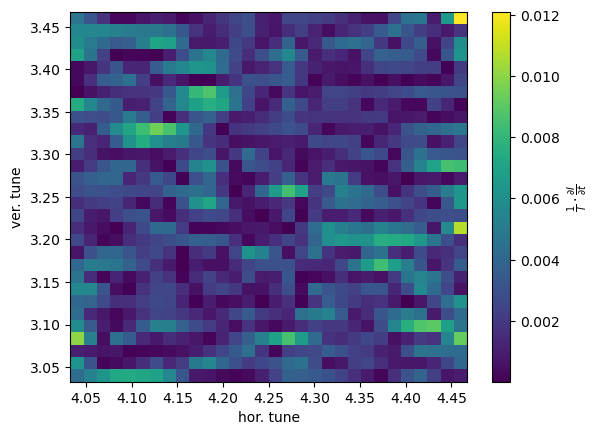

In [205]:
fig, ax = plt.subplots()

pcm = ax.pcolormesh(qx_range, qy_range, np.abs(result_scanInterpolated))

cbar = fig.colorbar(pcm)

# make nice
ax.set_xlabel("hor. tune")
ax.set_ylabel("ver. tune")
cbar.set_label(r"$\frac{1}{I} \cdot \frac{\partial I}{\partial t}$")

# debug